<a href="https://colab.research.google.com/github/MadugulaMeenakshi/-_1/blob/main/Assignment_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Problem Statement: Build a blight model using Decision Trees and Random Forests

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)).

Blight violations are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

We provide you with a data file for use in training and validating your models: blight_data.csv. Each row in the file corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible.


**Data fields**


    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction]
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [45]:
filepath ='/content/blight_data_train.csv'
df = pd.read_csv(filepath,encoding = 'ISO-8859-1')
df = df[['disposition', 'fine_amount',
        'late_fee', 'discount_amount',
        'clean_up_cost', 'judgment_amount', 'grafitti_status','compliance']]
df.head()

,disposition,fine_amount,late_fee,discount_amount,clean_up_cost,judgment_amount,grafitti_status,compliance
0,Responsible by Default,250.0,25.0,0.0,0.0,305.0,NaN,0.0
1,Responsible by Determination,750.0,75.0,0.0,0.0,855.0,NaN,1.0
2,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,NaN,NaN
3,Not responsible by City Dismissal,250.0,0.0,0.0,0.0,0.0,NaN,NaN
4,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,NaN,NaN


In [46]:
df.shape

(250306, 8)

In [48]:
df.isnull().sum()

disposition             0
fine_amount             1
late_fee                0
discount_amount         0
clean_up_cost           0
judgment_amount         0
grafitti_status    250305
compliance          90426
dtype: int64

In [49]:
df1 = df.drop(['grafitti_status','clean_up_cost'], axis = 1)
df1.head()

,disposition,fine_amount,late_fee,discount_amount,judgment_amount,compliance
0,Responsible by Default,250.0,25.0,0.0,305.0,0.0
1,Responsible by Determination,750.0,75.0,0.0,855.0,1.0
2,Not responsible by Dismissal,250.0,0.0,0.0,0.0,NaN
3,Not responsible by City Dismissal,250.0,0.0,0.0,0.0,NaN
4,Not responsible by Dismissal,250.0,0.0,0.0,0.0,NaN


In [50]:
df1.describe()

,fine_amount,late_fee,discount_amount,judgment_amount,compliance
count,250305.000000,250306.000000,250306.000000,250306.000000,159880.000000
mean,374.423435,21.494506,0.125167,268.685356,0.072536
std,707.195807,56.464263,3.430178,626.915212,0.259374
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,200.000000,0.000000,0.000000,0.000000,0.000000
50%,250.000000,10.000000,0.000000,140.000000,0.000000
75%,250.000000,25.000000,0.000000,305.000000,0.000000
max,10000.000000,1000.000000,350.000000,11030.000000,1.000000


In [51]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250306 entries, 0 to 250305
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   disposition      250306 non-null  object 
 1   fine_amount      250305 non-null  float64
 2   late_fee         250306 non-null  float64
 3   discount_amount  250306 non-null  float64
 4   judgment_amount  250306 non-null  float64
 5   compliance       159880 non-null  float64
dtypes: float64(5), object(1)
memory usage: 11.5+ MB


In [52]:
df1.isnull().sum()

disposition            0
fine_amount            1
late_fee               0
discount_amount        0
judgment_amount        0
compliance         90426
dtype: int64

In [53]:
df1.head()

,disposition,fine_amount,late_fee,discount_amount,judgment_amount,compliance
0,Responsible by Default,250.0,25.0,0.0,305.0,0.0
1,Responsible by Determination,750.0,75.0,0.0,855.0,1.0
2,Not responsible by Dismissal,250.0,0.0,0.0,0.0,NaN
3,Not responsible by City Dismissal,250.0,0.0,0.0,0.0,NaN
4,Not responsible by Dismissal,250.0,0.0,0.0,0.0,NaN


In [54]:
mean_values = df1.mean()

# Replace null values with the respective column mean
df1.fillna(mean_values, inplace=True)

In [55]:
df1.isnull().sum()

disposition        0
fine_amount        0
late_fee           0
discount_amount    0
judgment_amount    0
compliance         0
dtype: int64

Q. Are there any columns with null values?

In [56]:
#yes there are
print(df.isnull().any(axis=0))

disposition        False
fine_amount         True
late_fee           False
discount_amount    False
clean_up_cost      False
judgment_amount    False
grafitti_status     True
compliance          True
dtype: bool


Q. Which columns are categorical vs continuous? What is our target variable?

In [57]:
df.info()
#categorical = disposition
#target = compliance
#continuous =

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250306 entries, 0 to 250305
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   disposition      250306 non-null  object 
 1   fine_amount      250305 non-null  float64
 2   late_fee         250306 non-null  float64
 3   discount_amount  250306 non-null  float64
 4   clean_up_cost    250306 non-null  float64
 5   judgment_amount  250306 non-null  float64
 6   grafitti_status  1 non-null       object 
 7   compliance       159880 non-null  float64
dtypes: float64(6), object(2)
memory usage: 15.3+ MB


Q. There are two columns that needs to be dropped before building the models. What are those and why it needs to be dropped?

In [58]:
#clean up cost and grafitti_status
#graffiti_status column contains NaN values for all the rows
#clean_up_cost column contains all 0.0 values for all the rows

Q. Write a code to drop rows in df with null values. What percentage of rows have null values?

In [59]:
percentage_null_values = (df.isnull().mean() * 100).round(5)

print(percentage_null_values)

disposition         0.00000
fine_amount         0.00040
late_fee            0.00000
discount_amount     0.00000
clean_up_cost       0.00000
judgment_amount     0.00000
grafitti_status    99.99960
compliance         36.12618
dtype: float64


In [60]:
mean_values = df1.mean()

# Replace null values with the respective column mean
df1.fillna(mean_values, inplace=True)

In [61]:
df1.isnull().sum()

disposition        0
fine_amount        0
late_fee           0
discount_amount    0
judgment_amount    0
compliance         0
dtype: int64

Q. Convert categorical variables into dummy variables, and then apply *train_test_split* to split the data into training and test set. Use *random_state = 0* keeping other arguments at default.

In [62]:
df2 = pd.get_dummies(df1)
print(df2.head())

   fine_amount  late_fee  discount_amount  judgment_amount  compliance  \
0        250.0      25.0              0.0            305.0    0.000000   
1        750.0      75.0              0.0            855.0    1.000000   
2        250.0       0.0              0.0              0.0    0.072536   
3        250.0       0.0              0.0              0.0    0.072536   
4        250.0       0.0              0.0              0.0    0.072536   

   disposition_Not responsible by City Dismissal  \
0                                              0   
1                                              0   
2                                              0   
3                                              1   
4                                              0   

   disposition_Not responsible by Determination  \
0                                             0   
1                                             0   
2                                             0   
3                                     

In [63]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250306 entries, 0 to 250305
Data columns (total 14 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   fine_amount                                     250306 non-null  float64
 1   late_fee                                        250306 non-null  float64
 2   discount_amount                                 250306 non-null  float64
 3   judgment_amount                                 250306 non-null  float64
 4   compliance                                      250306 non-null  float64
 5   disposition_Not responsible by City Dismissal   250306 non-null  uint8  
 6   disposition_Not responsible by Determination    250306 non-null  uint8  
 7   disposition_Not responsible by Dismissal        250306 non-null  uint8  
 8   disposition_PENDING JUDGMENT                    250306 non-null  uint8  
 9   disposition_Responsible (F

In [64]:
df2 = df2.astype('int64')
df2.dtypes

fine_amount                                       int64
late_fee                                          int64
discount_amount                                   int64
judgment_amount                                   int64
compliance                                        int64
disposition_Not responsible by City Dismissal     int64
disposition_Not responsible by Determination      int64
disposition_Not responsible by Dismissal          int64
disposition_PENDING JUDGMENT                      int64
disposition_Responsible (Fine Waived) by Deter    int64
disposition_Responsible by Admission              int64
disposition_Responsible by Default                int64
disposition_Responsible by Determination          int64
disposition_SET-ASIDE (PENDING JUDGMENT)          int64
dtype: object

In [65]:
df2.shape

(250306, 14)

In [66]:
import pandas as pd
from sklearn.model_selection import train_test_split
X = df2.drop(['compliance'],axis = 1)
y = df2['compliance']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Q. Use the training set to train a dummy classifier (*from sklearn.dummy import DummyClassifier*) that classifies everything as the majority class (most_frequent strategy) of the training data. What is the accuracy and roc auc score of this classifier?

Note: For calculating roc auc score, you need to pass predicted probability by using *predict_proba* method. For example, for a classifier with name *'clf'*, predicted probability can be calculated by:

*y_clf_proba = clf.predict_proba(X_test)[:,1]*

In [68]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, roc_auc_score


dummy_classifier = DummyClassifier(strategy='most_frequent')
dummy_classifier.fit(X_train, y_train)

# Make predictions using the dummy classifier
y_pred = dummy_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate predicted probabilities using predict_proba method
y_dummy_proba = dummy_classifier.predict_proba(X_test)[:, 1]

# Calculating ROC AUC score
roc_auc = roc_auc_score(y_test, y_dummy_proba)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.9526847067597081
ROC AUC Score: 0.5


### Logistic Regression

Q. Use X_train to train two logistic regression model with fit_intercept= True and fit_intercept=False. Calculate the accuracy, confusion matrix, TPR and FPR. Also report the metrics if the probability threshold is changed to 0.3 and 0.7 .

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

logreg_intercept_true = LogisticRegression(fit_intercept=True)
logreg_intercept_true.fit(X_train, y_train)
y_prob_intercept_true = logreg_intercept_true.predict_proba(X_test)[:, 1]



logreg_intercept_false = LogisticRegression(fit_intercept=False)
logreg_intercept_false.fit(X_train, y_train)
y_prob_intercept_false = logreg_intercept_false.predict_proba(X_test)[:, 1]

thresholds = [0.3, 0.7]

for threshold in thresholds:
    y_pred_intercept_true = (y_prob_intercept_true >= threshold).astype(int)
    y_pred_intercept_false = (y_prob_intercept_false >= threshold).astype(int)

    # Calculate metrics for each model and threshold
    accuracy_intercept_true = accuracy_score(y_test, y_pred_intercept_true)
    accuracy_intercept_false = accuracy_score(y_test, y_pred_intercept_false)

    confusion_matrix_intercept_true = confusion_matrix(y_test, y_pred_intercept_true)
    confusion_matrix_intercept_false = confusion_matrix(y_test, y_pred_intercept_false)

    fpr_intercept_true, tpr_intercept_true, _ = roc_curve(y_test, y_prob_intercept_true)
    fpr_intercept_false, tpr_intercept_false, _ = roc_curve(y_test, y_prob_intercept_false)

    auc_intercept_true = auc(fpr_intercept_true, tpr_intercept_true)
    auc_intercept_false = auc(fpr_intercept_false, tpr_intercept_false)

    print(f"Threshold: {threshold}")
    print("Model with fit_intercept=True:")
    print("Accuracy:", accuracy_intercept_true)
    print("Confusion Matrix:\n", confusion_matrix_intercept_true)
    print("TPR:", tpr_intercept_true)
    print("FPR:", fpr_intercept_true)
    print("AUC:", auc_intercept_true)
    print("")

    print("Model with fit_intercept=False:")
    print("Accuracy:", accuracy_intercept_false)
    print("Confusion Matrix:\n", confusion_matrix_intercept_false)
    print("TPR:", tpr_intercept_false)
    print("FPR:", fpr_intercept_false)
    print("AUC:", auc_intercept_false)
    print("")







Threshold: 0.3
Model with fit_intercept=True:
Accuracy: 0.949248921323177
Confusion Matrix:
 [[70197  1342]
 [ 2469  1084]]
TPR: [0.         0.00337743 0.00365888 0.00478469 0.0059105  0.00816212
 0.00872502 0.01210245 0.05347594 0.05403884 0.06107515 0.0619195
 0.06839291 0.06923726 0.07064453 0.08387278 0.08443569 0.08471714
 0.0861244  0.08865747 0.08893892 0.09231635 0.0925978  0.10019702
 0.11398818 0.11455108 0.11483254 0.14466648 0.16633831 0.16690121
 0.18885449 0.20968196 0.21080777 0.21165212 0.21193358 0.21249648
 0.22094005 0.23050943 0.23276105 0.24767802 0.24767802 0.24795947
 0.24964818 0.26203209 0.26259499 0.30509429 0.3062201  0.3073459
 0.30762736 0.30762736 0.30847171 0.43850267 0.43878413 0.45088657
 0.45144948 0.49000844 0.52068674 0.52575288 0.52969322 0.53025612
 0.53110048 0.53110048 0.53194484 0.53278919 0.53278919 0.53729243
 0.53729243 0.53729243 0.54095131 0.54264002 0.54264002 0.54264002
 0.54292147 0.54320293 0.54461019 0.54489164 0.54489164 0.54545455
 0

In [70]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline,make_pipeline

model = make_pipeline(StandardScaler(),LogisticRegression())

model.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

Q. In the above question, according to you which is a better threshold for the problem statement.

In [71]:
#0.7 is better because accuracy  = 0.9558


Q. Report the Coefficients corresponding to eaach of the feaatures. How do these values explain the effect on the final classificaation outcome?

In [72]:
l = LogisticRegression()
l.fit(X_train, y_train)
# Get the coefficients
coefficients = l.coef_[0]

# Print the coefficients for each feature
for i, feature_name in enumerate(X.columns):
    print(f"Coefficient for {feature_name}: {coefficients[i]}")

Coefficient for fine_amount: -0.059916259792364646
Coefficient for late_fee: -0.07656331926408687
Coefficient for discount_amount: 0.1595150645220319
Coefficient for judgment_amount: 0.06033857353652188
Coefficient for disposition_Not responsible by City Dismissal: -0.3998384250710174
Coefficient for disposition_Not responsible by Determination: -0.08409107025482894
Coefficient for disposition_Not responsible by Dismissal: -0.8479290093468088
Coefficient for disposition_PENDING JUDGMENT: -0.007715495012320801
Coefficient for disposition_Responsible (Fine Waived) by Deter: 1.777346110992723
Coefficient for disposition_Responsible by Admission: -0.5164774451993732
Coefficient for disposition_Responsible by Default: -2.3958544639098447
Coefficient for disposition_Responsible by Determination: 0.09856909601860828
Coefficient for disposition_SET-ASIDE (PENDING JUDGMENT): -0.0034372092850151153


In [73]:

#A positive coefficient indicates that as the value of the independent variable increases, the mean of the dependent variable also tends to increase.
#A negative coefficient suggests that as the independent variable increases, the dependent variable tends to decrease.

Q. Plot the ROC curve

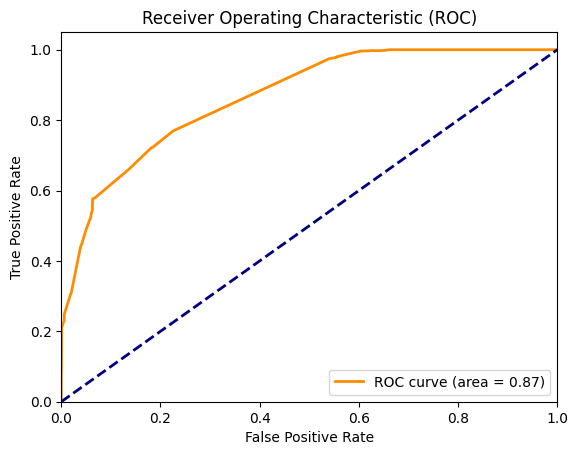

In [74]:
# Get predicted probabilities for the positive class (class 1)
y_pred_proba = l.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

### Decision Trees

Q. Use X_train to train a decision tree model using *DecisionTreeClassifier*, with max_depth = 3. Calculate the accuracy and roc auc score on X_test for this model.

In [75]:

from sklearn.tree import DecisionTreeClassifier


# Train a Decision Tree model with max_depth = 3
max_depth = 3
decision_tree = DecisionTreeClassifier(max_depth=max_depth)
decision_tree.fit(X_train, y_train)

# Make predictions on X_test
y_pred = decision_tree.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate predicted probabilities using predict_proba method
y_pred_proba = decision_tree.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)


Accuracy: 0.9621131412134448
ROC AUC Score: 0.7413516977450301


Q. Rank the feature importances of this classifier. Which is the most important feature used in the model?

In [77]:
feature_importances = decision_tree.feature_importances_
# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the ranked feature importances
print("Ranked Feature Importances:")
print(importance_df)

# Print the most important feature
most_important_feature = importance_df.iloc[0]['Feature']
print("\nMost Important Feature:", most_important_feature)

Ranked Feature Importances:
                                           Feature  Importance
2                                  discount_amount    0.365009
1                                         late_fee    0.239582
11        disposition_Responsible by Determination    0.207046
9             disposition_Responsible by Admission    0.188332
3                                  judgment_amount    0.000031
0                                      fine_amount    0.000000
4    disposition_Not responsible by City Dismissal    0.000000
5     disposition_Not responsible by Determination    0.000000
6         disposition_Not responsible by Dismissal    0.000000
7                     disposition_PENDING JUDGMENT    0.000000
8   disposition_Responsible (Fine Waived) by Deter    0.000000
10              disposition_Responsible by Default    0.000000
12        disposition_SET-ASIDE (PENDING JUDGMENT)    0.000000

Most Important Feature: discount_amount


Q. Fit 5 different Decision Tree classifier by varying the 'max_depth' parameter from 1 to 5. Plot the accuracy as a function of 'max_depth' parameter using the test dataset. At what 'max_depth' value does the classifier achieves maximum accuracy?

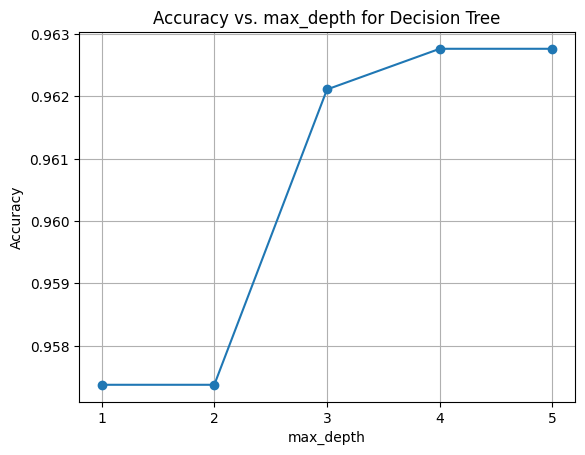

Max Accuracy: 0.9627656741064294
Best max_depth: 4


In [78]:
max_depth_values = range(1, 6)
accuracies = []

for i in max_depth_values:
    decision_tree = DecisionTreeClassifier(max_depth=i)
    decision_tree.fit(X_train, y_train)
    y_pred = decision_tree.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plotting accuracy as a function of max_depth
plt.plot(max_depth_values, accuracies, marker='o')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. max_depth for Decision Tree')
plt.xticks(max_depth_values)
plt.grid(True)
plt.show()

# Finding the max accuracy and corresponding max_depth
max_accuracy = max(accuracies)
best_max_depth = max_depth_values[accuracies.index(max_accuracy)]

print("Max Accuracy:", max_accuracy)
print("Best max_depth:", best_max_depth)



Q. What is 'max_depth' in decision tree model?

In [79]:

#max_depth is hyperparameter suggested the maximum depth that we allow the tree to grow to.
#The deeper is the tree, the more complex model will become
# Best max_depth: 4

Q. How does a decision tree algorithm decide where to split?

In [80]:

#Decision Tree algorithm selects the best attribute to split the data based on a metric such
#as entropy or Gini impurity, which measures the level of impurity or randomness.


Q. List one advantage and disadvatage of using decison tree model.

In [81]:
#ADVANTAGES OF DECISION TREE

'''
Can handle both categorical and numerical data
Can handle missing values and outliers
Can be used for classification and regression problems
'''

#DISADVANTAGES
'''
Overfitting can occur
Large decision trees can be hard to interpret
Decision trees can be sensitive to small changes in the data
'''


'\nOverfitting can occur\nLarge decision trees can be hard to interpret\nDecision trees can be sensitive to small changes in the data\n'

### Random Forests

Q. What is bagging? How is bagging used in Random Forests?

In [82]:
'''
Bagging is a technique to improve the stability and accuracy of machine learning algorithms.
It decreases the variance and helps to avoid overfitting
It helps improve machine learning results by combining several models.
'''

'\nBagging is a technique to improve the stability and accuracy of machine learning algorithms.\nIt decreases the variance and helps to avoid overfitting\nIt helps improve machine learning results by combining several models.\n'

Q. Build a random forest classifier using X_train. Experiment with different values of parameters such as *n_estimators*, *max_features* and *max_depth* to come up with a model such that roc auc score is maximized on X_test. Set *random_state = 0*.

In [83]:
from sklearn.ensemble import RandomForestClassifier
# Experimenting with different parameter values
best_roc_auc = 0
best_params = {}

for n_estimators in [50, 100, 150]:
    for max_features in ['auto', 'sqrt', 'log2']:
        for max_depth in [None, 5, 10]:
            # Build the Random Forest model
            rf_classifier = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, random_state=0)
            rf_classifier.fit(X_train, y_train)

            # Predict probabilities for positive class
            y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]

            # Calculate ROC AUC score
            roc_auc = roc_auc_score(y_test, y_pred_proba)

            # Update best parameters if ROC AUC score is improved
            if roc_auc > best_roc_auc:
                best_roc_auc = roc_auc
                best_params = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth}

print("Best ROC AUC Score:", best_roc_auc)
print("Best Parameters:", best_params)


Best ROC AUC Score: 0.8717228461730334
Best Parameters: {'n_estimators': 150, 'max_features': 'auto', 'max_depth': 10}


Q. What is the accuracy and roc auc score that you achieved on the test dataset? At what parameter values did you achieved this score?

Accuracy: 0.9638976189207905
ROC AUC Score: 0.8717228461730334


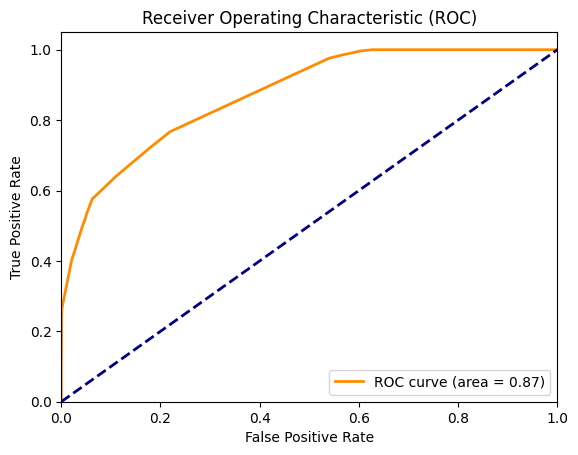

In [84]:
# Build the final Random Forest model using the best parameters
final_rf_classifier = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                                              max_features=best_params['max_features'],
                                              max_depth=best_params['max_depth'],
                                              random_state=0)
final_rf_classifier.fit(X_train, y_train)

# Predict on the test set and calculate accuracy
y_pred = final_rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


# Plot the ROC curve for the final Random Forest model
y_pred_proba_final = final_rf_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_final)
roc_auc = auc(fpr, tpr)
print("ROC AUC Score:", roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

Q. How are predictions made by a random forest regression and classification on a new data point?

In [93]:
#A random forest is a collection of Decision Trees, Each Tree independently makes a prediction,
# the values are then averaged (Regression) / Max voted (Classification) to arrive at the final value.
#At prediction time, the random forest algorithm averages each tree's prediction to compute the outcome for a given test instance.

Q. List one advantage and disadvatage of using a random forest model.

In [94]:
#Advantages
#It reduces overfitting in decision trees and helps to improve the accuracy
#It is flexible to both classification and regression problems
#It works well with both categorical and continuous values
#It automates missing values present in the data

#Disadvantages
#It requires much computational power as well as resources as it builds numerous trees to combine their outputs.
#It also requires much time for training as it combines a lot of decision trees to determine the class.


### K-Nearest Neighbors (KNN)

Q. Use *KNeighborsClassifier* in *sklearn.neighbors* to fit a model using training data set. Set n_neighbors = 5 keeping other parameters as default.

In [85]:
from sklearn.neighbors import KNeighborsClassifier
# Create a KNeighborsClassifier model with n_neighbors = 5
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Fit the model on the training data
knn_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = knn_classifier.predict(X_test)

# Print the predictions
print("Predictions:", y_pred)

Predictions: [0 0 0 ... 0 0 0]


Q. Use the testing dataset to calculate the accuracy, precision and recall of this classifier?

In [86]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Calculate accuracy, precision, and recall
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)





Accuracy: 0.9630586480583817
Precision: 0.8537693006357856
Recall: 0.26456515620602306


Q. Fit 20 different KNN classification model by varying the 'k' parameter from 1 to 20. Plot the accuracy as a function of 'k'
parameter using the test dataset. At what 'k' value does the classifier achieves maximum accuracy?

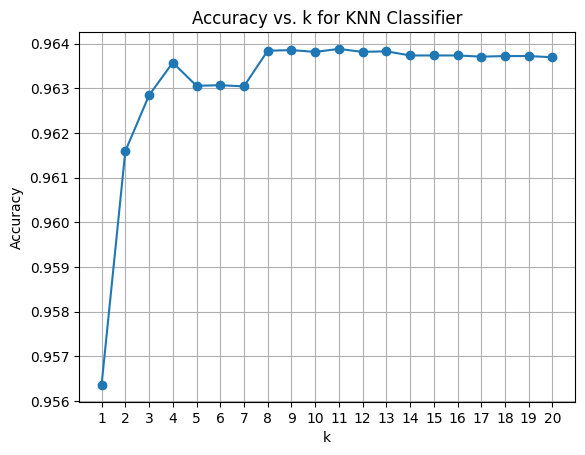

Max Accuracy: 0.9638843019229745
Best k: 11


In [87]:
# Varying k and calculating accuracy
k_values = range(1, 21)
accuracies = []


for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train, y_train)
    y_pred = knn_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plotting accuracy as a function of k
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k for KNN Classifier')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Finding the max accuracy and corresponding k value
max_accuracy = max(accuracies)
best_k = k_values[accuracies.index(max_accuracy)]

print("Max Accuracy:", max_accuracy)
print("Best k:", best_k)

Q. Fit the KNN model using the best 'k' value found. Calculate the accuracy, precision and recall for this new model? Comment if this model is better than the Dummy Classifier and why.

In [88]:

# Best k value found from previous step
best_k = 11

# Fit the KNN model using the best k value
knn_classifier = KNeighborsClassifier(n_neighbors=best_k)
knn_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = knn_classifier.predict(X_test)

# Calculate accuracy, precision, and recall
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the evaluation metrics for the KNN model
print("KNN Model Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

# Create a Dummy Classifier (most frequent strategy) for comparison
dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(X_train, y_train)
y_pred_dummy = dummy_classifier.predict(X_test)

# Calculate accuracy for the Dummy Classifier
accuracy_dummy = accuracy_score(y_test, y_pred_dummy)

# Print the accuracy of the Dummy Classifier
print("\nDummy Classifier Accuracy:", accuracy_dummy)

# Compare the KNN model's accuracy with the Dummy Classifier
if accuracy > accuracy_dummy:
    print("\nThe KNN model is better than the Dummy Classifier.")
else:
    print("\nThe KNN model is not better than the Dummy Classifier.")

KNN Model Metrics:
Accuracy: 0.9638843019229745
Precision: 0.9260385005065856
Recall: 0.25724739656628204

Dummy Classifier Accuracy: 0.9526847067597081

The KNN model is better than the Dummy Classifier.


Q. Briefly describe how KNN regression and classification predict on a new data point after a model is built?

In [89]:
#KNN works by finding the distances between a query and all the examples in the data, selecting the specified number examples (K) closest
# to the query, then votes for the most frequent label4
# (in the case of classification) or averages the labels (in the case of regression).

Q. What is one of the major drawback of using KNN?

In [95]:
#Does not work well with large dataset
#Does not work well with high dimensionality
#Sensitive to noisy and missing data

###  Support Vector Machines (SVM)

Q. Use SVC (Support Vector Classifier) to fit a model using training dataset. Use default model parameters.

In [90]:
from sklearn.svm import SVC

# Create an SVC model with default parameters
svc_classifier = SVC()

# Fit the model on the training data
svc_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = svc_classifier.predict(X_test)

# Print the predictions
print("Predictions:", y_pred)


Predictions: [0 0 0 ... 0 0 0]


Q. Use the testing data set to calculate the accuracy, precision and recall of this SVM classifier?

In [91]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the evaluation metrics for the SVM classifier
print("SVM Classifier Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

SVM Classifier Metrics:
Accuracy: 0.9530309487029244
Precision: 0.9642857142857143
Recall: 0.007599211933577259


Q. Use *kernel = 'rbf', gamma = 1e-07, C = 1e9* to train a SVM classifier model. Calculate the accuracy, precision and recall for this new model? Comment if this model is better than the Dummy Classifier and why.

In [92]:

# Create an SVM classifier model with specified parameters
svm_classifier = SVC(kernel='rbf', gamma=1e-07, C=1e9)

# Fit the model on the training data
svm_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_classifier.predict(X_test)

# Calculate accuracy, precision, and recall
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the evaluation metrics for the SVM classifier
print("SVM Classifier Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

# Create a Dummy Classifier (most frequent strategy) for comparison
dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(X_train, y_train)
y_pred_dummy = dummy_classifier.predict(X_test)

# Calculate accuracy for the Dummy Classifier
accuracy_dummy = accuracy_score(y_test, y_pred_dummy)

# Print the accuracy of the Dummy Classifier
print("\nDummy Classifier Accuracy:", accuracy_dummy)

# Compare the SVM model's accuracy with the Dummy Classifier
if accuracy > accuracy_dummy:
    print("\nThe SVM model is better than the Dummy Classifier.")
else:
    print("\nThe SVM model is not better than the Dummy Classifier.")


SVM Classifier Metrics:
Accuracy: 0.943988707185852
Precision: 0.4013893083660526
Recall: 0.37405009850830284

Dummy Classifier Accuracy: 0.9526847067597081

The SVM model is not better than the Dummy Classifier.


In [ ]:
'''# Calculate accuracy, precision, and recall
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the evaluation metrics for the SVM classifier
print("SVM Classifier Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

# Create a Dummy Classifier (most frequent strategy) for comparison
dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(X_train, y_train)
y_pred_dummy = dummy_classifier.predict(X_test)

# Calculate accuracy for the Dummy Classifier
accuracy_dummy = accuracy_score(y_test, y_pred_dummy)

# Print the accuracy of the Dummy Classifier
print("\nDummy Classifier Accuracy:", accuracy_dummy)

# Compare the SVM model's accuracy with the Dummy Classifier
if accuracy > accuracy_dummy:
    print("\nThe SVM model is better than the Dummy Classifier.")
else:
    print("\nThe SVM model is not better than the Dummy Classifier.")

'''



SVM Classifier Metrics:
Accuracy: 0.9457960253330422
Precision: 0.0
Recall: 0.0

Dummy Classifier Accuracy: 0.9457960253330422

The SVM model is not better than the Dummy Classifier.


Q. What is a kernel in SVM?

In [ ]:
#In a Support Vector Machine (SVM), a kernel is a mathematical function that allows the algorithm to transform input data from its original space
# into a higher-dimensional space. Kernels play a crucial role in SVM by enabling the algorithm to find complex, nonlinear decision boundaries
# in the transformed space, even if the original data might not be linearly separable.

Q. What does 'gamma' value in *rbf* kernel control?

In [ ]:
#In the Radial Basis Function (RBF) kernel of a Support Vector Machine (SVM), the 'gamma' parameter controls the "flexibility" or "reach" of the decision boundary.
# It determines how much influence each individual data point has on shaping the boundary.
#Low 'gamma': Wider influence, smoother boundary, less prone to overfitting.
#High 'gamma': Narrower influence, more complex boundary, potential overfitting.

Q. What is the significance of 'C' parameter in SVM?

In [ ]:
#The 'C' parameter in a Support Vector Machine (SVM) is a regularization parameter that controls the trade-off between maximizing
#the margin (distance between the decision boundary and the closest data points) and minimizing the classification error on the training data.
#It influences the balance between achieving a simple model and fitting the training data accurately.

Q. Briefly describe how SVM algorithm works?

In [ ]:
#Choosing the Best Line
#Support Vectors
#Getting Creative with the Line
#Kernels
#Making Predictions

Q. For fraud detection, which model would you choose among the three models built (Dummy, KNN, SVM) and why? What things would you consider while choosing the best model for your purpose?

In [ ]:
'''

Given these considerations, let's evaluate the three models:

1. **Dummy Classifier:** The Dummy Classifier simply predicts the majority class. It's unlikely to perform well for fraud detection due to its simplicity and
inability to capture complex patterns.

2. **KNN:** KNN can be effective if feature engineering is done well and the dataset isn't too large. However, it might struggle with high-dimensional data
 and imbalanced classes. Proper tuning of 'k' and handling of class imbalance are critical.

3. **SVM:** SVMs are powerful and can handle high-dimensional data. With proper parameter tuning and feature scaling, SVMs can be effective for fraud detection.
 The choice of the right kernel and regularization parameters is crucial.

Considering these factors, an SVM with an appropriate kernel and well-tuned hyperparameters might be a better choice for fraud detection.
 However, it's essential to evaluate each model's performance using cross-validation and thoroughly analyze precision-recall trade-offs to make an informed decision.
 Additionally, experimenting with ensemble methods (e.g., Random Forest, Gradient Boosting) and anomaly detection algorithms
 (e.g., Isolation Forest, One-Class SVM) might also be beneficial. Ultimately, the choice should be based on a balance between performance, interpretability, scalability,
 and the specific requirements of the fraud detection problem.